In [1]:
import cv2

def load_image(image_path):
    image = cv2.imread(image_path)
    return image
image_path = "/content/sample.jpg"
image = load_image(image_path)


In [2]:
def convert_to_grayscale(image):
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return grayscale_image

grayscale_image = convert_to_grayscale(image)


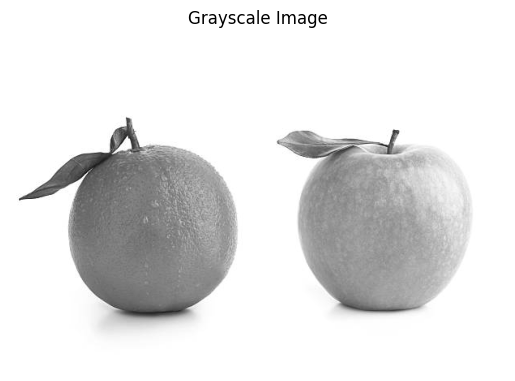

In [3]:
import matplotlib.pyplot as plt

def show_image(image, title="Image"):
    if len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

show_image(grayscale_image, title="Grayscale Image")


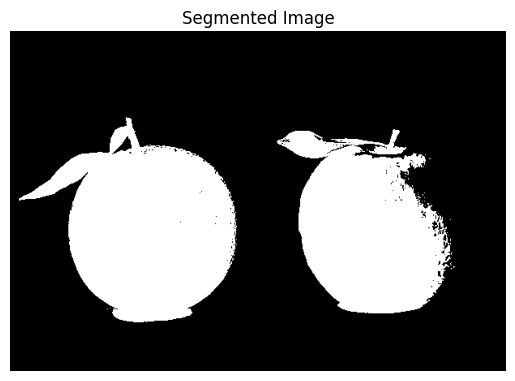

In [4]:
def segment_image(image):
    gray = convert_to_grayscale(image)
    _, thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return thresholded

thresholded_image = segment_image(image)
show_image(thresholded_image, title="Segmented Image")


In [5]:
import numpy as np
import pandas as pd

def extract_features(image, thresholded):
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    features = {
        "Area": [],
        "Perimeter": [],
        "Bounding Box": [],
        "Centroid": [],
        "Color Histogram": []
    }

    gray = convert_to_grayscale(image)  

    for contour in contours:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        x, y, w, h = cv2.boundingRect(contour)
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            cX, cY = 0, 0

        mask = np.zeros(gray.shape, np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, -1)
        masked_img = cv2.bitwise_and(image, image, mask=mask)
        hist = cv2.calcHist([masked_img], [0, 1, 2], mask, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()

        features["Area"].append(area)
        features["Perimeter"].append(perimeter)
        features["Bounding Box"].append((x, y, w, h))
        features["Centroid"].append((cX, cY))
        features["Color Histogram"].append(hist.tolist())  

    return pd.DataFrame(features)

features_df = extract_features(image, thresholded_image)
features_df.head()


,Area,Perimeter,Bounding Box,Centroid,Color Histogram
0,0.0,0.000000,"(120, 342, 1, 1)","(0, 0)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0.0,0.000000,"(123, 341, 1, 1)","(0, 0)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0.0,2.000000,"(544, 292, 1, 2)","(0, 0)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0.5,3.414214,"(547, 290, 2, 2)","(547, 290)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0.0,7.656854,"(543, 285, 2, 4)","(0, 0)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [8]:
import ast
import os

def create_reference_features():
    reference_images = {
        "orange": "/content/orangesample1.jpg",
        "green_apple": "/content/applesample1.jpg"
    }
    reference_features = {}

    for label, img_path in reference_images.items():
        features_csv = f"{label}_features.csv"
        if os.path.exists(features_csv):
            print(f"Loading saved features for {label} from {features_csv}")
            reference_features[label] = pd.read_csv(features_csv, converters={"Color Histogram": ast.literal_eval})
        else:
            print(f"Extracting and saving features for {label}")
            image = load_image(img_path)
            thresholded = segment_image(image)
            features_df = extract_features(image, thresholded)
            features_df.to_csv(features_csv, index=False)
            reference_features[label] = features_df

    return reference_features

reference_features = create_reference_features()


Loading saved features for orange from orange_features.csv
Loading saved features for green_apple from green_apple_features.csv


In [9]:
from scipy.spatial import distance

def compare_features(reference_features, target_histogram):
    best_match = None
    best_distance = float('inf')

    for label, ref_features_df in reference_features.items():
        for ref_index, ref_row in ref_features_df.iterrows():
            ref_histogram = np.array(ref_row["Color Histogram"])
            dist = distance.euclidean(ref_histogram, target_histogram)

            if dist < best_distance:
                best_distance = dist
                best_match = label

    return best_match, best_distance

example_histogram = features_df["Color Histogram"][0] 
best_match, best_distance = compare_features(reference_features, example_histogram)
print(f"Best Match: {best_match}, Distance: {best_distance}")


Best Match: orange, Distance: 1.4142135565042568


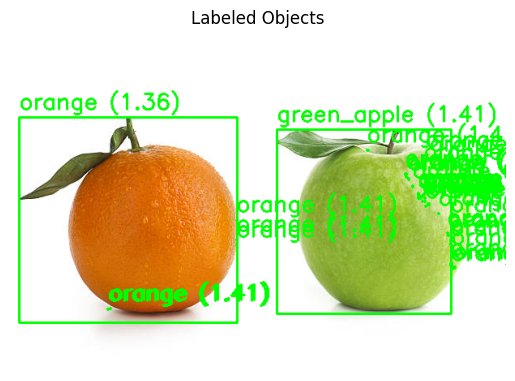

In [10]:

def detect_and_label_objects(image, thresholded, reference_features):
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cropped_image = image[y:y+h, x:x+w]
        mask = np.ones(cropped_image.shape[:2], dtype="uint8") * 255
        hist = cv2.calcHist([cropped_image], [0, 1, 2], mask, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()

        label, similarity_index = compare_features(reference_features, hist)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        label_text = f"{label} ({similarity_index:.2f})"
        cv2.putText(image, label_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    return image

labeled_image = detect_and_label_objects(image, thresholded_image, reference_features)

show_image(labeled_image, title="Labeled Objects")


In [11]:
# Step 9: Save and visualize the result
detected_image_path = "labeled_image.jpg"
cv2.imwrite(detected_image_path, labeled_image)

print(f"Detected and labeled image saved as {detected_image_path}")


Detected and labeled image saved as labeled_image.jpg
